# GIN Experiment
This notebook will implement the evaluation pipeline with the FID calculation using the GIN

## Setup

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from tqdm import tqdm

from util import load_data, load_synth_data, separate_data , load_graph_asS2Vgraph
from models.graphcnn import GraphCNN


criterion = nn.CrossEntropyLoss()

In [2]:
def train(iters_per_epoch, batch_size, model, device, train_graphs, optimizer, epoch):
    model.train()

    total_iters = iters_per_epoch
    pbar = tqdm(range(total_iters), unit='batch')

    loss_accum = 0
    for pos in pbar:
        selected_idx = np.random.permutation(len(train_graphs))[:batch_size]

        batch_graph = [train_graphs[idx] for idx in selected_idx]
        output = model(batch_graph)

        labels = torch.LongTensor([graph.label for graph in batch_graph]).to(device)

        #compute loss
        loss = criterion(output, labels)

        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()
        

        loss = loss.detach().cpu().numpy()
        loss_accum += loss

        #report
        pbar.set_description('epoch: %d' % (epoch))

    average_loss = loss_accum/total_iters
    print("loss training: %f" % (average_loss))
    
    return average_loss

###pass data to model with minibatch during testing to avoid memory overflow (does not perform backpropagation)
def pass_data_iteratively(model, graphs, minibatch_size = 64):
    model.eval()
    output = []
    idx = np.arange(len(graphs))
    for i in range(0, len(graphs), minibatch_size):
        sampled_idx = idx[i:i+minibatch_size]
        if len(sampled_idx) == 0:
            continue
        output.append(model([graphs[j] for j in sampled_idx]).detach())
    return torch.cat(output, 0)

def test(model, device, train_graphs, test_graphs, epoch):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_train = correct / float(len(train_graphs))

    output = pass_data_iteratively(model, test_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in test_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_test = correct / float(len(test_graphs))

    print("accuracy train: %f test: %f" % (acc_train, acc_test))

    return acc_train, acc_test

## Training settings

In [3]:
dataset = None
device = 0 
batch_size = 32
iters_per_epoch = 50
epochs = 60
lr = 0.01
seed = 0
fold_idx = 1
num_layers = 5
num_mlp_layers = 3
hidden_dim = 64
final_dropout = 0.5
graph_pooling_type = "sum"
neighbor_pooling_type = "sum"
learn_eps = False
degree_as_tag = True
filename = ""
random = 1

## Training 

In [4]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)    
device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

if dataset != None :
    graphs, num_classes = load_data(dataset, degree_as_tag)
else :
    graphs, num_classes, tagset , lentagset = load_synth_data(True, random)
num_classes
##10-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
train_graphs, test_graphs = separate_data(graphs, seed, fold_idx)

model = GraphCNN(num_layers, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, num_classes, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type,0, device).to(device)

optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch,batch_size,model, device, train_graphs, optimizer, epoch)
    acc_train, acc_test = test( model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

loading data
# classes: 5
# maximum node tag: 66
# data: 4000


/home/ousmanetouat/anaconda3/envs/graphRL/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch: 1: 100%|██████████| 50/50 [00:03<00:00, 13.39batch/s]


loss training: 8.646901
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0164, 0.0557, 0.0585, 0.0324], device='cuda:0', requires_grad=True)


epoch: 2: 100%|██████████| 50/50 [00:02<00:00, 22.63batch/s]


loss training: 0.831721
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0513, 0.0771, 0.1266, 0.0710], device='cuda:0', requires_grad=True)


epoch: 3: 100%|██████████| 50/50 [00:02<00:00, 22.56batch/s]


loss training: 0.263683
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0358, 0.0888, 0.1750, 0.0995], device='cuda:0', requires_grad=True)


epoch: 4: 100%|██████████| 50/50 [00:02<00:00, 19.74batch/s]


loss training: 0.275711
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0647, 0.1015, 0.1643, 0.1211], device='cuda:0', requires_grad=True)


epoch: 5: 100%|██████████| 50/50 [00:02<00:00, 22.75batch/s]


loss training: 0.132151
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0758, 0.1307, 0.2288, 0.1689], device='cuda:0', requires_grad=True)


epoch: 6: 100%|██████████| 50/50 [00:02<00:00, 22.62batch/s]


loss training: 0.279531
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.0529, 0.1149, 0.2091, 0.2145], device='cuda:0', requires_grad=True)


epoch: 7: 100%|██████████| 50/50 [00:02<00:00, 23.52batch/s]


loss training: 7.456157
accuracy train: 0.999444 test: 1.000000

Parameter containing:
tensor([0.1667, 0.2539, 0.4087, 0.2684], device='cuda:0', requires_grad=True)


epoch: 8: 100%|██████████| 50/50 [00:02<00:00, 22.56batch/s]


loss training: 0.877555
accuracy train: 0.999722 test: 1.000000

Parameter containing:
tensor([0.2092, 0.2952, 0.4165, 0.3319], device='cuda:0', requires_grad=True)


epoch: 9: 100%|██████████| 50/50 [00:02<00:00, 22.34batch/s]


loss training: 0.321721
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2178, 0.3101, 0.4161, 0.3600], device='cuda:0', requires_grad=True)


epoch: 10: 100%|██████████| 50/50 [00:02<00:00, 22.50batch/s]


loss training: 0.137747
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2188, 0.3149, 0.4317, 0.3612], device='cuda:0', requires_grad=True)


epoch: 11: 100%|██████████| 50/50 [00:02<00:00, 22.73batch/s]


loss training: 0.133970
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2147, 0.2990, 0.4166, 0.3629], device='cuda:0', requires_grad=True)


epoch: 12: 100%|██████████| 50/50 [00:02<00:00, 23.03batch/s]


loss training: 0.022208
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2180, 0.2979, 0.4130, 0.3644], device='cuda:0', requires_grad=True)


epoch: 13: 100%|██████████| 50/50 [00:02<00:00, 23.14batch/s]


loss training: 0.254182
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2239, 0.2697, 0.3694, 0.3651], device='cuda:0', requires_grad=True)


epoch: 14: 100%|██████████| 50/50 [00:02<00:00, 19.73batch/s]


loss training: 0.129578
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2207, 0.2743, 0.3836, 0.3632], device='cuda:0', requires_grad=True)


epoch: 15: 100%|██████████| 50/50 [00:02<00:00, 22.89batch/s]


loss training: 0.083898
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2147, 0.2679, 0.3800, 0.3600], device='cuda:0', requires_grad=True)


epoch: 16: 100%|██████████| 50/50 [00:02<00:00, 22.36batch/s]


loss training: 0.321419
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2091, 0.3262, 0.3685, 0.3608], device='cuda:0', requires_grad=True)


epoch: 17: 100%|██████████| 50/50 [00:02<00:00, 22.47batch/s]


loss training: 0.178317
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2078, 0.3339, 0.3984, 0.3803], device='cuda:0', requires_grad=True)


epoch: 18: 100%|██████████| 50/50 [00:02<00:00, 23.02batch/s]


loss training: 0.191655
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2022, 0.3437, 0.4151, 0.3802], device='cuda:0', requires_grad=True)


epoch: 19: 100%|██████████| 50/50 [00:02<00:00, 22.83batch/s]


loss training: 0.122306
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2046, 0.3433, 0.3852, 0.3784], device='cuda:0', requires_grad=True)


epoch: 20: 100%|██████████| 50/50 [00:02<00:00, 22.84batch/s]


loss training: 0.152811
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1861, 0.3506, 0.4057, 0.3796], device='cuda:0', requires_grad=True)


epoch: 21: 100%|██████████| 50/50 [00:02<00:00, 22.56batch/s]


loss training: 0.038282
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1848, 0.3565, 0.4207, 0.3804], device='cuda:0', requires_grad=True)


epoch: 22: 100%|██████████| 50/50 [00:02<00:00, 22.66batch/s]


loss training: 0.009987
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1876, 0.3581, 0.4213, 0.3803], device='cuda:0', requires_grad=True)


epoch: 23: 100%|██████████| 50/50 [00:02<00:00, 22.68batch/s]


loss training: 0.008554
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1871, 0.3575, 0.4219, 0.3804], device='cuda:0', requires_grad=True)


epoch: 24: 100%|██████████| 50/50 [00:02<00:00, 22.48batch/s]


loss training: 0.008894
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1869, 0.3574, 0.4205, 0.3803], device='cuda:0', requires_grad=True)


epoch: 25: 100%|██████████| 50/50 [00:02<00:00, 19.52batch/s]


loss training: 0.042388
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1927, 0.3574, 0.4222, 0.3806], device='cuda:0', requires_grad=True)


epoch: 26: 100%|██████████| 50/50 [00:02<00:00, 22.85batch/s]


loss training: 0.011200
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1927, 0.3576, 0.4248, 0.3815], device='cuda:0', requires_grad=True)


epoch: 27: 100%|██████████| 50/50 [00:02<00:00, 22.71batch/s]


loss training: 0.009893
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1927, 0.3576, 0.4250, 0.3814], device='cuda:0', requires_grad=True)


epoch: 28: 100%|██████████| 50/50 [00:02<00:00, 21.98batch/s]


loss training: 0.005272
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1927, 0.3576, 0.4255, 0.3815], device='cuda:0', requires_grad=True)


epoch: 29: 100%|██████████| 50/50 [00:02<00:00, 19.17batch/s]


loss training: 0.005807
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1927, 0.3578, 0.4270, 0.3814], device='cuda:0', requires_grad=True)


epoch: 30: 100%|██████████| 50/50 [00:02<00:00, 23.34batch/s]


loss training: 0.023583
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1864, 0.3578, 0.4268, 0.3828], device='cuda:0', requires_grad=True)


epoch: 31: 100%|██████████| 50/50 [00:02<00:00, 22.94batch/s]


loss training: 0.690770
accuracy train: 0.985278 test: 0.995000

Parameter containing:
tensor([0.2122, 0.3707, 0.4418, 0.3819], device='cuda:0', requires_grad=True)


epoch: 32: 100%|██████████| 50/50 [00:02<00:00, 23.18batch/s]


loss training: 1.028156
accuracy train: 0.995278 test: 0.997500

Parameter containing:
tensor([0.0609, 0.4271, 0.5027, 0.3825], device='cuda:0', requires_grad=True)


epoch: 33: 100%|██████████| 50/50 [00:02<00:00, 23.23batch/s]


loss training: 4.977467
accuracy train: 0.999444 test: 0.997500

Parameter containing:
tensor([0.1145, 0.5597, 0.7912, 0.6544], device='cuda:0', requires_grad=True)


epoch: 34: 100%|██████████| 50/50 [00:02<00:00, 20.06batch/s]


loss training: 1.763717
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2490, 0.6600, 0.9246, 0.7810], device='cuda:0', requires_grad=True)


epoch: 35: 100%|██████████| 50/50 [00:02<00:00, 22.82batch/s]


loss training: 0.380538
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.3012, 0.6972, 0.9254, 0.6895], device='cuda:0', requires_grad=True)


epoch: 36: 100%|██████████| 50/50 [00:02<00:00, 22.83batch/s]


loss training: 0.092178
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2910, 0.7008, 0.9264, 0.6887], device='cuda:0', requires_grad=True)


epoch: 37: 100%|██████████| 50/50 [00:02<00:00, 23.19batch/s]


loss training: 0.105702
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2899, 0.7023, 0.9451, 0.6909], device='cuda:0', requires_grad=True)


epoch: 38: 100%|██████████| 50/50 [00:02<00:00, 20.08batch/s]


loss training: 0.055809
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2886, 0.7060, 0.9110, 0.6908], device='cuda:0', requires_grad=True)


epoch: 39: 100%|██████████| 50/50 [00:02<00:00, 23.32batch/s]


loss training: 0.020765
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2919, 0.7105, 0.9171, 0.6910], device='cuda:0', requires_grad=True)


epoch: 40: 100%|██████████| 50/50 [00:02<00:00, 23.27batch/s]


loss training: 0.007074
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.2918, 0.7105, 0.9177, 0.6906], device='cuda:0', requires_grad=True)


epoch: 41: 100%|██████████| 50/50 [00:02<00:00, 23.03batch/s]


loss training: 0.412934
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1610, 0.5590, 0.9170, 0.6906], device='cuda:0', requires_grad=True)


epoch: 42: 100%|██████████| 50/50 [00:02<00:00, 23.16batch/s]


loss training: 0.149997
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1189, 0.4997, 0.9244, 0.6898], device='cuda:0', requires_grad=True)


epoch: 43: 100%|██████████| 50/50 [00:02<00:00, 23.15batch/s]


loss training: 0.167182
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1302, 0.4990, 0.9317, 0.6896], device='cuda:0', requires_grad=True)


epoch: 44: 100%|██████████| 50/50 [00:02<00:00, 20.01batch/s]


loss training: 0.183159
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1585, 0.5165, 0.9404, 0.6899], device='cuda:0', requires_grad=True)


epoch: 45: 100%|██████████| 50/50 [00:02<00:00, 23.27batch/s]


loss training: 0.157938
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1493, 0.5334, 0.9428, 0.6903], device='cuda:0', requires_grad=True)


epoch: 46: 100%|██████████| 50/50 [00:02<00:00, 23.11batch/s]


loss training: 0.023095
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1504, 0.5342, 0.9425, 0.6906], device='cuda:0', requires_grad=True)


epoch: 47: 100%|██████████| 50/50 [00:02<00:00, 23.23batch/s]


loss training: 0.015521
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1506, 0.5343, 0.9425, 0.6907], device='cuda:0', requires_grad=True)


epoch: 48: 100%|██████████| 50/50 [00:02<00:00, 22.93batch/s]


loss training: 0.012138
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1572, 0.5371, 0.9449, 0.6907], device='cuda:0', requires_grad=True)


epoch: 49: 100%|██████████| 50/50 [00:02<00:00, 19.85batch/s]


loss training: 0.005767
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1574, 0.5372, 0.9451, 0.6907], device='cuda:0', requires_grad=True)


epoch: 50: 100%|██████████| 50/50 [00:02<00:00, 21.80batch/s]


loss training: 0.005630
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1574, 0.5372, 0.9455, 0.6907], device='cuda:0', requires_grad=True)


epoch: 51: 100%|██████████| 50/50 [00:02<00:00, 22.98batch/s]


loss training: 0.020995
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1568, 0.5281, 0.9469, 0.6907], device='cuda:0', requires_grad=True)


epoch: 52: 100%|██████████| 50/50 [00:02<00:00, 22.23batch/s]


loss training: 0.002974
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1567, 0.5272, 0.9474, 0.6907], device='cuda:0', requires_grad=True)


epoch: 53: 100%|██████████| 50/50 [00:02<00:00, 23.00batch/s]


loss training: 0.011093
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1567, 0.5275, 0.9520, 0.6907], device='cuda:0', requires_grad=True)


epoch: 54: 100%|██████████| 50/50 [00:02<00:00, 19.89batch/s]


loss training: 0.006009
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1567, 0.5276, 0.9523, 0.6908], device='cuda:0', requires_grad=True)


epoch: 55: 100%|██████████| 50/50 [00:02<00:00, 22.24batch/s]


loss training: 0.024546
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1512, 0.5284, 0.9573, 0.6908], device='cuda:0', requires_grad=True)


epoch: 56: 100%|██████████| 50/50 [00:02<00:00, 22.28batch/s]


loss training: 0.004432
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1509, 0.5284, 0.9576, 0.6907], device='cuda:0', requires_grad=True)


epoch: 57: 100%|██████████| 50/50 [00:02<00:00, 22.61batch/s]


loss training: 0.006224
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1509, 0.5285, 0.9582, 0.6907], device='cuda:0', requires_grad=True)


epoch: 58: 100%|██████████| 50/50 [00:02<00:00, 20.06batch/s]


loss training: 0.006726
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1510, 0.5286, 0.9583, 0.6907], device='cuda:0', requires_grad=True)


epoch: 59: 100%|██████████| 50/50 [00:02<00:00, 22.50batch/s]


loss training: 0.006875
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1510, 0.5286, 0.9582, 0.6908], device='cuda:0', requires_grad=True)


epoch: 60: 100%|██████████| 50/50 [00:02<00:00, 22.73batch/s]


loss training: 0.004307
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0.1510, 0.5286, 0.9583, 0.6908], device='cuda:0', requires_grad=True)


In [5]:
output = pass_data_iteratively(model, graphs)

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

/home/ousmanetouat/anaconda3/envs/graphRL/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 [Text(2.52752,-22.2101,'0'),
  Text(-47.8774,7.71783,'1'),
  Text(7.97872,33.3077,'2'),
  Text(46.4973,3.82391,'3'),
  Text(12.0847,-67.5283,'4')])

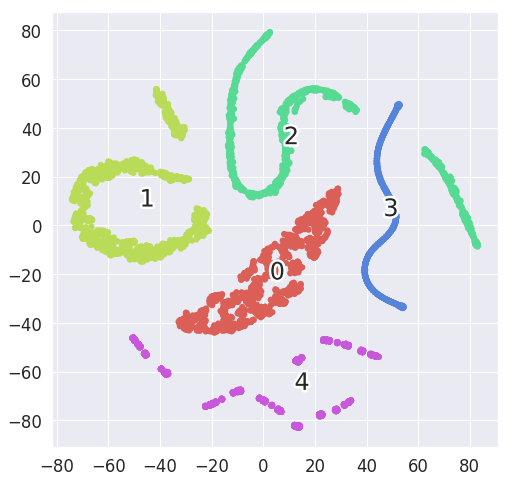

In [7]:
X=output.cpu()
y = np.array([g.label for g in graphs])
############################################################
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=0).fit_transform(X)
fashion_scatter(fashion_tsne, y)

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [9]:
import networkx as nx
from scipy import linalg
## Coming from https://github.com/mseitzer/pytorch-fid
def compute_FID(mu1, mu2, cov1, cov2, eps = 1e-6):
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert cov1.shape == cov2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(cov1.shape[0]) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(cov1) +
            np.trace(cov2) - 2 * tr_covmean)

def compute_fid(ref_graph,ref_label,pred_graph,model):
    device = 0
    num_layers = 5
    num_mlp_layers = 2
    hidden_dim = 64
    final_dropout = 0.5
    graph_pooling_type = "sum"
    neighbor_pooling_type = "sum"
    learn_eps = False
    
    #set up seeds and gpu device
    torch.manual_seed(0)
    np.random.seed(0)
    device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)
    #model = GraphCNN(num_layers, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, 5, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type, 'cpu').to('cpu')
    #model.load_checkpoint()
    #model.eval()


    with torch.no_grad():
        embed_graphs_ref = pass_data_iteratively(model,ref_graph)
        embed_graphs_ref=embed_graphs_ref.cpu().detach().numpy()
        mu_ref = np.mean(embed_graphs_ref, axis = 0)
        cov_ref = np.cov(embed_graphs_ref, rowvar = False)

        embed_graphs_pred = pass_data_iteratively(model,pred_graph)
        embed_graphs_pred=embed_graphs_pred.cpu().detach().numpy()
        mu_pred = np.mean(embed_graphs_pred, axis = 0)
        cov_pred = np.cov(embed_graphs_pred, rowvar = False)

    fid = compute_FID(mu_ref,mu_pred,cov_ref,cov_pred)
    return fid

def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

In [10]:
from util import load_graph_list
graph_grid_test=load_graph_list('saved_graphs/grid_test.p',False)
graph_grid_gen=load_graph_list('../../generated_graphs/grid_GRANMixtureBernoulli_DFS.p',False)
graph2= []
npr = np.random.RandomState(1)
npr.shuffle(graph_grid_test)
graph_grid_test=graph_grid_test[:100]
for k in range(10,20):
    for j in range(10,20):
        graph2.append(nx.grid_2d_graph(k,j))
graph_grid_gen_rnn=load_graph_list('../../generated_graphs/grid_RNN_BFS.p',False)
graph_grid_gen_mlp=load_graph_list('../../generated_graphs/grid_RNN_MLP_BFS.p',False)
g_list_ref,_ = load_graph_asS2Vgraph(graph_grid_test,4,random,tagset , lentagset)
g_list_pred,_ = load_graph_asS2Vgraph(graph_grid_gen,4,random, tagset , lentagset)
g_list_pred2,_ = load_graph_asS2Vgraph(graph2,4,random, tagset , lentagset)
g_list_pred_rnn,_ = load_graph_asS2Vgraph(graph_grid_gen_rnn,4,random, tagset , lentagset)
g_list_pred_mlp,_ = load_graph_asS2Vgraph(graph_grid_gen_mlp,4,random, tagset , lentagset)
print(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==4],2,g_list_pred2,model))
print(compute_fid(graphs,2,g_list_pred,model))
print(compute_fid(g_list_ref,2,g_list_pred_rnn,model))
print(compute_fid(g_list_ref,2,g_list_pred_mlp,model))
test_acc(model,'cuda:0',[graphs[i] for i in range(len(graphs)) if graphs[i].label ==4])
test_acc(model,'cuda:0',g_list_pred)
test_acc(model,'cuda:0',g_list_pred_rnn)
test_acc(model,'cuda:0',g_list_pred_mlp)

# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 4
# data: 100
# classes: 1
# maximum node tag: 3
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100
# classes: 1
# maximum node tag: 8
# data: 100


ValueError: Imaginary component 0.0016702553786435213

In [11]:
graph_ba_test=load_graph_list('saved_graphs/barabasi_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ba_test)
graph_ba_test=graph_ba_test[:500]
graph_ba_gen_dd=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_degree_decent.p',False)
graph_ba_gen_bfs=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_BFS.p',False)
graph_ba_gen_dfs=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_DFS.p',False)
graph_ba_gen_kcore=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_k_core.p',False)
graph_ba_gen_noorder=load_graph_list('../../generated_graphs/barabasi_GRANMixtureBernoulli_no_order.p',False)
graph_ba_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.barabasi_albert_graph(i,4)
        graph_ba_regen.append(g)
g_list_ref_ba,_ = load_graph_asS2Vgraph(graph_ba_test,2,random, tagset , lentagset)
g_list_ref_ba_regen,_ = load_graph_asS2Vgraph(graph_ba_regen,2,random, tagset , lentagset)
g_list_ref_ba_dd,_ = load_graph_asS2Vgraph(graph_ba_gen_dd,2,random, tagset , lentagset)
g_list_ref_ba_bfs,_ = load_graph_asS2Vgraph(graph_ba_gen_bfs,2,random, tagset , lentagset)
g_list_ref_ba_dfs,_ = load_graph_asS2Vgraph(graph_ba_gen_dfs,2,random, tagset , lentagset)
g_list_ref_ba_kcore,_ = load_graph_asS2Vgraph(graph_ba_gen_kcore,2,random, tagset , lentagset)
g_list_ref_ba_no,_ = load_graph_asS2Vgraph(graph_ba_gen_noorder,2,random, tagset , lentagset)
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_regen,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_dd,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_bfs,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_dfs,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_kcore,model))
print(compute_fid(g_list_ref_ba,2,g_list_ref_ba_no,model))

test_acc(model,'cuda:0',g_list_ref_ba)
test_acc(model,'cuda:0',g_list_ref_ba_dd)
test_acc(model,'cuda:0',g_list_ref_ba_bfs)
test_acc(model,'cuda:0',g_list_ref_ba_dfs)
test_acc(model,'cuda:0',g_list_ref_ba_kcore)
test_acc(model,'cuda:0',g_list_ref_ba_no)

# classes: 1
# maximum node tag: 63
# data: 500
# classes: 1
# maximum node tag: 66
# data: 500
# classes: 1
# maximum node tag: 65
# data: 500
# classes: 1
# maximum node tag: 64
# data: 500


IndexError: index 68 is out of bounds for dimension 1 with size 66

In [ ]:
graph_ws_test=load_graph_list('saved_graphs/watts_test.p',False)
npr = np.random.RandomState(1)
npr.shuffle(graph_ws_test)
graph_ws_test=graph_ba_test[:500]
graph_ws_gen_dd=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_degree_descent.p',False)
graph_ws_gen_bfs=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_BFS.p',False)
graph_ws_gen_dfs=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_DFS.p',False)
graph_ws_gen_kcore=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_k_core.p',False)
graph_ws_gen_noorder=load_graph_list('../../generated_graphs/wattsSW_GRANMixtureBernoulli_no_order.p',False)
graph_ws_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.watts_strogatz_graph(i,4,0.1)
        graph_ws_regen.append(g)
g_list_ref_ws,_ = load_graph_asS2Vgraph(graph_ws_test,1,random, tagset , lentagset)
g_list_ref_ws_regen,_ = load_graph_asS2Vgraph(graph_ws_regen,1,random, tagset , lentagset)
g_list_ref_ws_dd,_ = load_graph_asS2Vgraph(graph_ws_gen_dd,1,random, tagset , lentagset)
g_list_ref_ws_bfs,_ = load_graph_asS2Vgraph(graph_ws_gen_bfs,1,random, tagset , lentagset)
g_list_ref_ws_dfs,_ = load_graph_asS2Vgraph(graph_ws_gen_dfs,1,random, tagset , lentagset)
g_list_ref_ws_kcore,_ = load_graph_asS2Vgraph(graph_ws_gen_kcore,1,random, tagset , lentagset)
g_list_ref_ws_no,_ = load_graph_asS2Vgraph(graph_ws_gen_noorder,1,random, tagset , lentagset)
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_regen,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dd,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_bfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_dfs,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_kcore,model))
print(compute_fid(g_list_ref_ws,1,g_list_ref_ws_no,model))

test_acc(model,'cuda:0',g_list_ref_ws)
test_acc(model,'cuda:0',g_list_ref_ws_dd)
test_acc(model,'cuda:0',g_list_ref_ws_bfs)
test_acc(model,'cuda:0',g_list_ref_ws_dfs)
test_acc(model,'cuda:0',g_list_ref_ws_kcore)
test_acc(model,'cuda:0',g_list_ref_ws_no)

# classes: 1
# maximum node tag: 66
# data: 500
# classes: 1
# maximum node tag: 7
# data: 500
# classes: 1
# maximum node tag: 16
# data: 500
# classes: 1
# maximum node tag: 29
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 10
# data: 500
# classes: 1
# maximum node tag: 25
# data: 500
783485.8193198056
989262.8440599522
843365.3730332404
1058043.5003389467
857574.5138306125
1016323.2973010978
accuracy : 0.000000
accuracy : 0.994000
accuracy : 0.978000
accuracy : 0.982000
accuracy : 0.994000
accuracy : 1.000000


1.0

In [13]:
def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

graph_com2_test=load_graph_list('saved_graphs/community2_test.p',False)
graph_com2_gen_dd=load_graph_list('../../generated_graphs/community2small_GRANMixtureBernoulli_DFS.p',False)
graph3=[]
for i in range(500):
    c_sizes = np.random.choice(list(range(12, 17)), 2)
    graph3.append(n_community(c_sizes, p_inter=0.05))
g_list_ref_com2,_ = load_graph_asS2Vgraph(graph_com2_test,3,random, tagset , lentagset)
g_list_pred_com2,_ = load_graph_asS2Vgraph(graph_com2_gen_dd,3,random, tagset , lentagset)
g_list_pred_com3,_ = load_graph_asS2Vgraph(graph3,3,random, tagset , lentagset)
print(compute_fid(g_list_ref_com2,1,g_list_pred_com2,model))
print(compute_fid(g_list_ref_com2,1,g_list_pred_com3,model))
test_acc(model,'cuda:0',g_list_ref_com2)
test_acc(model,'cuda:0',g_list_pred_com2)

# classes: 1
# maximum node tag: 15
# data: 1000
# classes: 1
# maximum node tag: 17
# data: 500
# classes: 1
# maximum node tag: 15
# data: 500
5473053.705843424
208.33437900349963
accuracy : 0.000000
accuracy : 0.000000


0.0

In [ ]:
def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

test_acc(model,'cuda:0',g_list_pred_rnn)

accuracy : 1.000000


1.0